In [1]:
import pandas as pd
# pd.options.display.max_colwidth = 200

import numpy as np
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

from pymystem3 import Mystem; mystem = Mystem()
from functools import lru_cache


from tqdm import tqdm
tqdm.pandas()

%matplotlib inline

# Data overview

In [2]:
data = pd.read_csv('./DATA_MANY_TOPICS.csv')

In [3]:
data.sample(5)

,index,text,title,topic,url
26549,26549,"\n\n Сделка по продаже 19,5% акций «Рос...",\n Акционеры из BP и члены ...,business,http://www.vedomosti.ru/business/news/2017/01/...
87627,87627,"Российский боксер Денис Лебедев, выступающий в...",Денис Лебедев огласил планы по возвращению на ...,boxing,https://lenta.ru/news/2013/05/29/lebedev/
137228,137232,"Первый матч 1/8 финала Лиги Европы между ""Рост...","Немецкая бригада обслужит матч ""Ростов"" - ""Ман...",football,http://www.sport-express.ru/football/europa-le...
17361,17361,"\n Акционеры ""Уралкалия"" на годовом собрании ...","\n ""Уралкалий"" выплатит 11,...",business,http://www.vedomosti.ru/business/news/2014/06/...
166849,166866,"Нападающий московского ""Динамо"" Артем Федоров ...","Артем Федоров: ""В матчах с ""Трактором"" и ""Сала...",hockey,http://www.sport-express.ru/hockey/khl/news/ar...


In [4]:
print('Number of news:', len(data))

Number of news: 188028


In [5]:
print('Number of topics:', data.topic.nunique())

Number of topics: 32


In [6]:
data = data[~((data.topic == 'forces') & (data.url.str.contains('https://www.gazeta.ru/')))]

In [7]:
data.topic.value_counts()

football           31993
business           28022
politics           22849
hockey             11400
technologies        7097
films               6592
science             5558
crime               5308
internet            5067
realty              4878
basketball          4480
judiciary           4165
weapons             4120
forces              3993
music               3809
tennis              3571
auto                3453
companies           3316
cosmos              2732
boxing              2512
economics           2426
biathlon            2235
social-networks     2039
cybersport          1835
formula1            1433
animals             1225
books                939
religion             903
theatre              882
skiing               696
volleyball           528
chess                473
Name: topic, dtype: int64

In [8]:
class Pipeline(object):
    def __init__(self, *args):
        self.transformations = args
    def __call__(self, x):
        res = x
        for f in self.transformations:
            res = f(res)
        return res

In [9]:
from nltk.corpus import stopwords
from stop_words import get_stop_words
en_sw = get_stop_words('en')
ru_sw = get_stop_words('ru')
STOP_WORDS = set(en_sw) | set(ru_sw)
STOP_WORDS = STOP_WORDS | set(stopwords.words('russian')) | set(stopwords.words('english'))
STOP_WORDS = STOP_WORDS | set(['лента', 'новость', 'риа', 'тасс',
                               'редакция', 'газета', 'корра', 'daily',
                               'village', 'интерфакс', 'reuters'])

def remove_ria(text):
    prefix = text[:50]
    ria = 'РИА Новости'
    if ria in prefix:
        text = text[text.find(ria)+len(ria)+1:]
    return text

def remove_tass(text):
    prefix = text[:100]
    return text[max(0, prefix.find('/.')+1):]

def get_lower(text):
    return str(text).lower().strip()

def remove_punctuation(text):
    return ''.join([c if c.isalpha() or c in ['-',"'"] else ' ' for c in text])

@lru_cache(maxsize=None)
def get_word_normal_form(word):
    return ''.join(mystem.lemmatize(word)).strip().replace('ё', 'е').strip('-')

def lemmatize_words(text):
    res = []
    for word in text.split():
        norm_form = get_word_normal_form(word)
        if len(norm_form) > 2 and norm_form not in STOP_WORDS:
            res.append(norm_form)
    return ' '.join(res)

In [10]:
TEXT_PIPELINE = Pipeline(remove_tass, remove_ria, get_lower, remove_punctuation, lemmatize_words)

In [11]:
%%time
data.text = data.text.progress_apply(TEXT_PIPELINE)

100%|██████████| 180529/180529 [01:19<00:00, 2273.59it/s]


CPU times: user 57.8 s, sys: 2.79 s, total: 1min
Wall time: 1min 19s


In [12]:
%%time
data.title = data.title.progress_apply(TEXT_PIPELINE)

100%|██████████| 180529/180529 [00:03<00:00, 48694.74it/s]


CPU times: user 3.39 s, sys: 48 ms, total: 3.44 s
Wall time: 3.72 s


In [13]:
vocabulary = defaultdict(int)
for news in data.itertuples():
    for word in news.text.split():
        vocabulary[word] += 1
print('Unique words in dataset:', len(vocabulary))

Unique words in dataset: 246038


In [14]:
n_min_occurance = 2
print('Number of words occured more than %d times: %d' % 
      (n_min_occurance, len(list(filter(lambda x: x[1] >= n_min_occurance, vocabulary.items())))))

Number of words occured more than 2 times: 144456


In [15]:
top_k = 25
print('Top %d most frequent words:' % top_k)
for i, (word, freq) in enumerate(sorted(vocabulary.items(), key=lambda x: -x[1])[:top_k]):
    print(i+1, word, freq)

Top 25 most frequent words:
1 россия 127360
2 компания 109475
3 сообщать 102989
4 свой 85740
5 российский 68955
6 становиться 64901
7 матч 64332
8 слово 60927
9 заявлять 59660
10 отмечать 55122
11 команда 50941
12 млрд 50432
13 страна 49104
14 президент 48788
15 получать 48404
16 сша 47990
17 новый 46498
18 млн 42251
19 ранее 41067
20 руб 39573
21 чемпионат 38149
22 данный 37871
23 москва 37448
24 представитель 37279
25 составлять 36976


## Undersampling

In [16]:
data.drop(data[data.topic == 'football'].sample(20000).index, inplace=True)
data.drop(data[data.topic == 'business'].sample(18000).index, inplace=True)
data.drop(data[data.topic == 'politics'].sample(11000).index, inplace=True)

In [24]:
data.topic.value_counts(normalize=True)*100

football           9.118141
politics           9.008660
hockey             8.667290
business           7.619612
technologies       5.395768
films              5.011822
science            4.225684
crime              4.035612
internet           3.852382
realty             3.708688
basketball         3.406093
judiciary          3.166602
weapons            3.132389
forces             3.035832
music              2.895939
tennis             2.714991
auto               2.625277
companies          2.521117
cosmos             2.077108
boxing             1.909845
economics          1.844460
biathlon           1.699245
social-networks    1.550228
cybersport         1.395130
formula1           1.089494
animals            0.931354
books              0.713911
religion           0.686541
theatre            0.670575
skiing             0.529161
volleyball         0.401432
chess              0.359617
Name: topic, dtype: float64

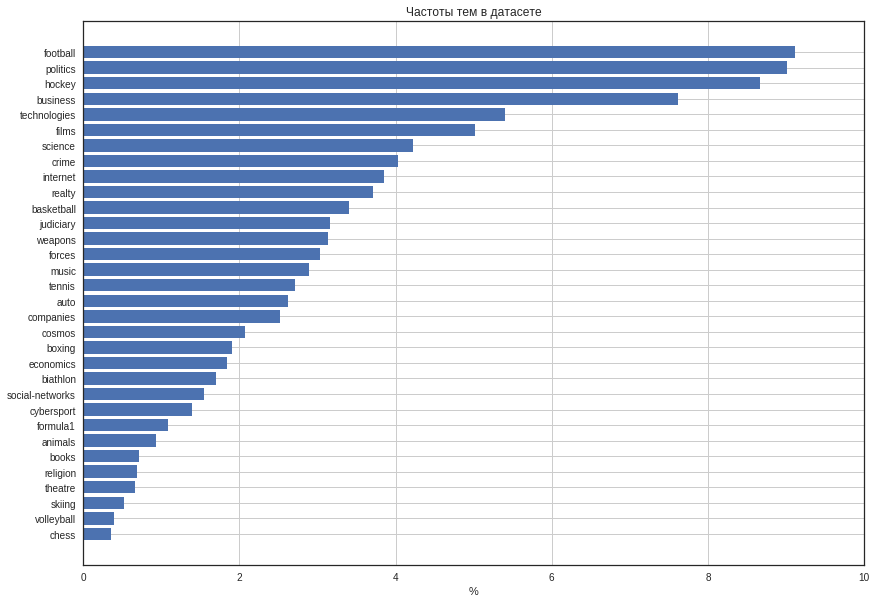

In [21]:
topics_freq = data.topic.value_counts(normalize=True, ascending=True)*100
plt.figure(figsize=(14,10))
plt.barh(range(len(topics_freq)), topics_freq.values)
plt.yticks(range(len(topics_freq)), topics_freq.index);
plt.xticks(np.arange(0, 11, 2));
plt.xlabel('%')
plt.grid(True)
plt.title('Частоты тем в датасете');

# Baseline

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer
from sklearn.svm import LinearSVC

from scipy.sparse import hstack

## Закодируем целевую переменную

In [26]:
le = LabelEncoder()
data.topic = le.fit_transform(data.topic)

## Разделим данные на train и validation

In [27]:
trainX = data.title + ' ' + data.text
trainX = np.swapaxes(np.vstack([trainX.values, data.url.values]), 0, 1)
trainY = data.topic.values

In [28]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.5, stratify=trainY, random_state=42)

## Вычислим tf-idf

In [29]:
%%time
tfidf_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,2), lowercase=False).fit(trainX[:,0])

CPU times: user 1min, sys: 488 ms, total: 1min
Wall time: 1min


In [30]:
len(tfidf_vectorizer.vocabulary_)

512045

In [31]:
X_train_tf = tfidf_vectorizer.transform(X_train[:,0])
X_test_tf = tfidf_vectorizer.transform(X_test[:,0])

## Обучим SVM

In [48]:
# clf = LinearSVC(C=1, max_iter=10000, loss='hinge', random_state=42)
clf = SGDClassifier(loss='hinge', n_iter=50, random_state=42, n_jobs=8, alpha=1e-5)

In [49]:
%%time
clf.fit(X_train_tf, y_train)
clf_prediciton = clf.predict(X_test_tf)
print('F1 score:', f1_score(y_test, clf_prediciton, average='macro'))
print('Accuracy:', accuracy_score(y_test, clf_prediciton))

# F1 score: 0.88541391699
# Accuracy: 0.883859195621

F1 score: 0.885214515859
Accuracy: 0.884543450163
CPU times: user 3min 14s, sys: 40 ms, total: 3min 14s
Wall time: 49.3 s


## Построим нормализованную матрицу потерь

In [50]:
cm = confusion_matrix(y_test, clf_prediciton)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

In [51]:
classes = [c for c in le.classes_]
df_cm = pd.DataFrame(np.round(cm_normalized, 2), columns=classes, index=classes)

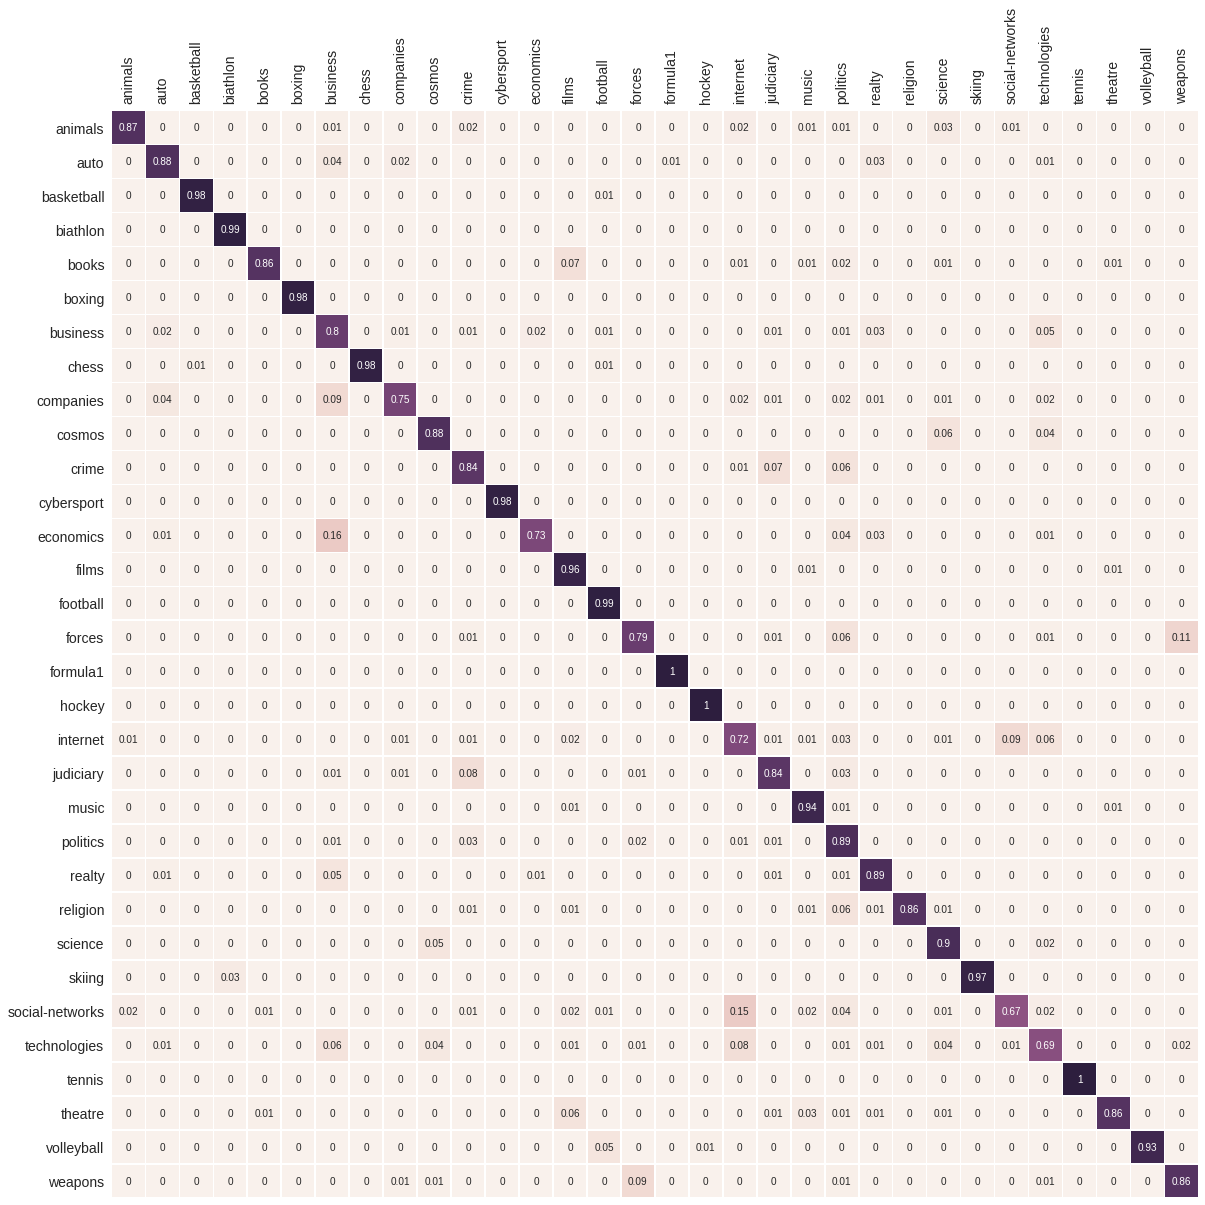

In [52]:
sns.set_context("notebook", font_scale=1.4);
plt.figure(figsize=(20, 20))
ax = sns.heatmap(df_cm, annot=True, linewidths=.5, fmt='g', cbar=False, square=True, annot_kws={"size": 10});
ax.xaxis.tick_top()
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);

In [53]:
class_scores = {}
for i in range(cm_normalized.shape[0]):
    class_scores[classes[i]] = cm_normalized[i,i]

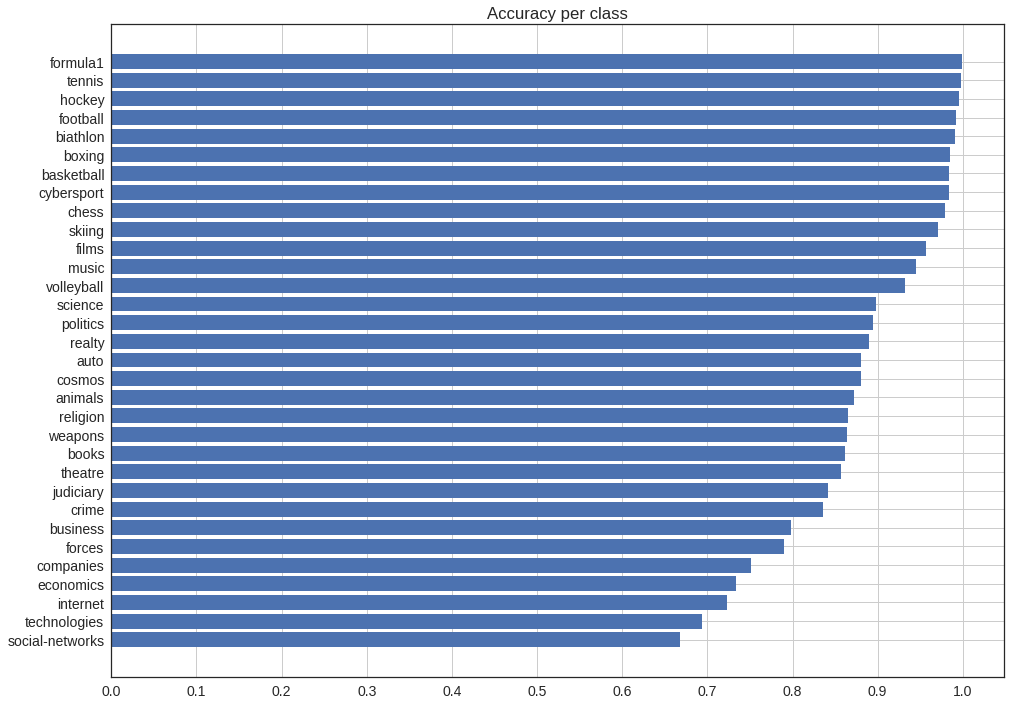

In [54]:
topics = []
scores = []
for topic, score in sorted(class_scores.items(), key=lambda x: x[1]):
    topics.append(topic)
    scores.append(score)
plt.figure(figsize=(16,12))
plt.barh(range(len(topics)), scores)
plt.yticks(range(len(topics)), topics);
plt.xticks(np.arange(0, 1.001, 0.1));
plt.grid(True)
plt.title('Accuracy per class');

## Посмотрим на ошибки классификации

In [55]:
for i, (true, pred) in enumerate(zip(y_test, clf_prediciton)):
    if true == le.transform(['technologies'])[0] and pred == le.transform(['realty'])[0]:
        print(X_test[i][1])

http://www.vedomosti.ru/technology/articles/2015/01/13/schetnaya-palata-podschitala-tehnoparki
http://www.vedomosti.ru/technology/articles/2010/07/30/rosreestr-sozdaet-cifrovuyu-kartu-nedvizhimosti-rossii
http://www.vedomosti.ru/technology/news/2011/11/24/ceul_priznan_samym_umnym_gorodom_mira
https://lenta.ru/news/2015/12/01/kingdomtower/
http://www.vedomosti.ru/technology/news/2013/02/26/na_kosmodrome_vostochnyj_stroitelstvo_ostavshihsya_obektov
http://www.vedomosti.ru/technology/news/2011/08/22/yandeks_mozhet_postroit_v_tulskoj_oblasti_centr_obrabotki
http://www.vedomosti.ru/technology/articles/2013/04/22/des_moines_register_facebook_postroit_novyj
http://www.vedomosti.ru/technology/news/2013/04/12/putin_predlozhit_nazvat_v_chest_ciolkovskogo_gorod_u
http://www.vedomosti.ru/technology/news/2012/08/21/shojgu-raskritikoval-kachestvo-sotovoj-svyazi-v-podmoskove
http://www.vedomosti.ru/technology/news/2013/01/17/v_kazhdoj_moskovskoj_shkole_poyavyatsya_16_kamer
http://www.vedomosti.ru/tec

## Выведем слова с максимальным весом внутри каждого класса

In [56]:
def print_top_K(vectorizer, clf, class_labels, k=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    top_words = []
    for i, class_label in enumerate(class_labels):
        top_K = np.argsort(clf.coef_[i])[-k:]
        top_words.append([feature_names[j] for j in top_K])
#         print('%s: %s' % (class_label, ' '.join(feature_names[j] for j in top_K)))
    return pd.DataFrame(top_words, index=class_labels)

In [57]:
print_top_K(tfidf_vectorizer, clf, le.classes_, k=10)

,0,1,2,3,4,5,6,7,8,9
animals,котенок,крокодил,медведь,пес,вольер,питомец,животный,зоопарк,животное,кличка
auto,техосмотр,группа газ,пробка,авторынок,автозавод,автопром,автопроизводитель,камаз,автоваз,автомобиль
basketball,рфб,единый лига,евробаскет,баскетбольный,центровой,кубок европа,баскетбол,баскетболист,евролига,нба
biathlon,эстафета,касперович,домрачева,биатлонистка,сбр,шипулин,хохфильцен,биатлон,ibu,биатлонист
books,писательница,произведение,издательство,книжный,роман,комикс,литературный,поэт,книга,писатель
boxing,мма,алоян,боец,ринг,лебзяк,поветкин,поединок,бой,бокс,боксер
business,авиакомпания,алроса,россия футбол,оао,rusal,fifa,ржд,formula,ритейлер,туроператор
chess,кирсан,шахматы,костенюк,магнус,карлсен,гроссмейстер,шахматный,фид,карякин,илюмжинов
companies,миллиард кубометр,миллиард,тысяча автомобиль,компания,кубометр,миллион тонна,процент акция,тысяча,ретейлер,процент
cosmos,астрофизик,солнечный,международный космический,миссия,спутник,мкс,космонавт,вселенная,астронавт,марс


In [58]:
test_str = '''В 1969-72 годах американские астронавты установили на Луне в общей сложности шесть звездно-полосатых флагов.
С тех пор прошло много лет и утекло много лунного песка. Несмотря на отсутствие воздуха флаги за это время сильно износились.
В последний раз их видели в 2012 году, когда их снял Лунный орбитальный зонд (LRO). Тогда как минимум пять из шести флагов
находились в вертикальном положении. Однако после десятилетий, проведенных на ярком солнце, цвета, конечно же, выгорели.
По мнению ученых, сейчас флаги скорее всего почти полностью белого цвета. Все флаги стоили 5,5 долларов (32 доллара в современных ценах).
Компания AnninFlagmakers изготовила их из вискозы, волокна которой под воздействием ультрафиолетового света распадаются.
Это значит, что ткань флагов не только полностью выгорела, но и, не исключено, очень сильно обветшала. К этому следует добавить, пишет
Metro, и температурные условия: две недели ярчайшего солнца и стоградусной жары, за которыми следуют две недели лунной ночи, когда
столбик термометра, если бы он был на это рассчитан, опускался бы до отметки -150°С. НАСА менять флаги на Луне не собирается.
Агентство намерено отправлять астронавтов в далекий космос, но спутник Земли космические начальники решили облететь стороной.
В планах полет на Марс примерно в 2033 году. Последняя надежда осталась на коммерческие компании, осваивающие космос.
Не исключено, что вместо госагентства звездно-полосатые флаги на нашем спутнике заменит владелец Amazon, мультимиллардер Джефф Безос,
который мечтает о колонизации Луны.'''

In [59]:
le.inverse_transform(clf.predict(tfidf_vectorizer.transform([TEXT_PIPELINE(test_str)])))[0]

'cosmos'